In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

# Chapter2

## 用户行为分析

### 用户活跃度和物品流行度的分布

In [3]:
from main.util.movielen_reader import read_rating_data
from main.util import movielen_reader

movieLen_data, _ = read_rating_data("data/ml-1m/ratings.dat")
movieLen_df = pd.DataFrame(movieLen_data,columns = ["userID","movieID","Rating"])
movieLen_df.head()

,userID,movieID,Rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [4]:
sum_movie_rating = (
    movieLen_df[["userID","movieID"]].groupby(["movieID"],as_index = False).count())
sum_movie_rating.rename(
                mapper = {"userID" : "Item Popularity"},
                axis = 1,
                inplace = True
)
sum_movie_rating = sum_movie_rating.groupby("Item Popularity",as_index = False).count()
sum_movie_rating.rename(
                mapper = {"movieID" : "counts"},
                axis = 1,
                inplace = True
)
sum_movie_rating["log_Item_Popularity"] = np.log10(sum_movie_rating["Item Popularity"])
sum_movie_rating.head()

,Item Popularity,counts,log_Item_Popularity
0,1,114,0.000000
1,2,89,0.301030
2,3,42,0.477121
3,4,45,0.602060
4,5,39,0.698970


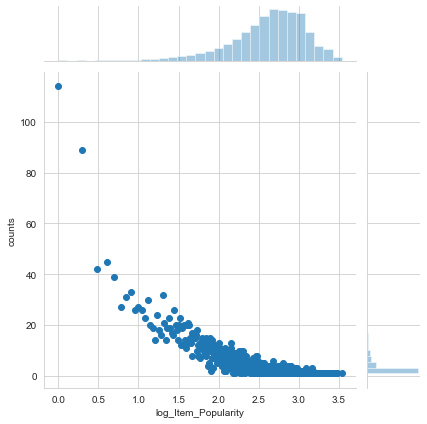

In [5]:
import seaborn as sns

sns.set_style("whitegrid")
axe = sns.jointplot(x = "log_Item_Popularity",y = "counts",data = sum_movie_rating)

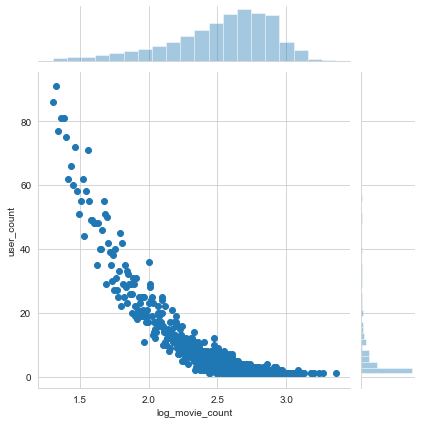

In [7]:
import seaborn as sns

item_popularity = movieLen_df.groupby(["userID"],as_index = False).count()
item_popularity.rename(mapper = {"movieID" : "movie_count"},axis = 1,inplace = True)
item_popularity = item_popularity.groupby(["movie_count"],as_index = False).count()
item_popularity.rename(mapper = {"userID" : "user_count"},axis = 1,inplace = True)
item_popularity["log_movie_count"] = np.log10(item_popularity.movie_count)

sns.set_style("whitegrid")

sns.jointplot(data = item_popularity,x = "log_movie_count",y = "user_count")

### 用户活跃度和物品流行度的关系

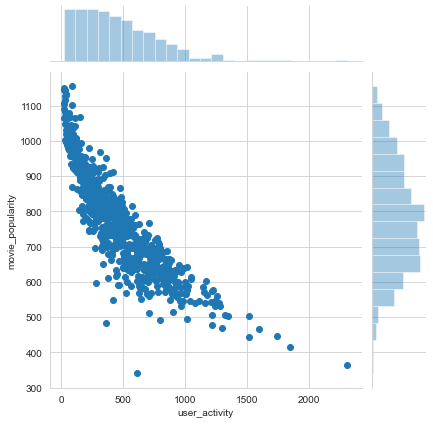

In [8]:
import seaborn as sns

user_activity = movieLen_df[["userID","movieID"]].groupby("userID").count()
user_activity.rename({"movieID" : "user_activity"},axis = 1,inplace = True)

movie_popularity = (movieLen_df[["userID","movieID"]].
                                groupby("movieID",as_index = False).count())
movie_popularity.rename({"userID" : "movie_popularity"},axis = 1,inplace = True)


combine = pd.merge(left = movieLen_df,right = user_activity,on = "userID")
combine = pd.merge(left = combine,right = movie_popularity,on = "movieID")

combine = combine.groupby(["user_activity"],as_index = False).mean()

sns.set_style("whitegrid")
sns.jointplot(data = combine,x = "user_activity",y = "movie_popularity");

## 基于邻域方法

### ＵSERCF

#### Load Data

In [9]:
from main.chapter2 import usercf
from main.util import movielen_reader

trainset,testset = movielen_reader.read_rating_data(path="data/ml-1m/ratings.dat", train_rate = 0.8)

#### Training 

In [11]:
uf = usercf.UserCF()
uf.train(trainset)

开始训练模型
开始载入用户协同矩阵....
载入用户协同过滤矩阵失败，重新计算协同过滤矩阵


KeyboardInterrupt: 

#### Evaluation

In [4]:
test = dict()
for user,item,_ in testset:
    test.setdefault(user,list())
    test[user].append(item)

In [5]:
def train_popularity(train):
    """计算训练集的流行度"""
    train_popularity = dict()
    for user,item,_ in train:
        train_popularity.setdefault(item,0)
        train_popularity[item] += 1
    return train_popularity

In [6]:
from main.util import metric
from main.util import movielen_reader
import pandas as pd

def evaluate(N,K):
    """评价模型
        Args:
            N:　　　　推荐的商品个数
            K:　　　　搜索邻近的用户个数
        Return:
            精确率,召回率,覆盖率,流行度
    """
    recommens = uf.recommend_users(test.keys(),N = N,K = K)
    all_items = movielen_reader.all_items()
    item_popularity = train_popularity(trainset)

    recall = metric.recall(recommends = recommens,tests=test)
    precision = metric.precision(recommends = recommens,tests = test)
    coverage = metric.coverage(recommends = recommens,all_items = all_items)
    popularity = metric.popularity(item_popular = item_popularity,recommends = recommens)
    
    return precision,recall,coverage,popularity


In [7]:
N = 30   #表示推荐的商品个数
K_list = [5,10,20,40,80,160]  #表示临近用户的list
evals = list()

for k in K_list:
    single_eval = evaluate(N = N,K = k)
    evals.append(single_eval)

In [8]:
pd.DataFrame(
        data = evals,
        index = K_list,
        columns = ["Precision","Recall","Coverage","Popularity"]
)

,Precision,Recall,Coverage,Popularity
5,0.187374,0.206607,0.709120,6.571688
10,0.215727,0.237871,0.576902,6.727978
20,0.234815,0.258917,0.469239,6.844714
40,0.244026,0.269073,0.389099,6.941994
80,0.244296,0.269371,0.310847,7.028955
160,0.237698,0.262096,0.246087,7.112617


### USER-IIF

USER-IIF在UserCF的基础上考虑了物品的流行度，触使算法推荐比较冷门的物品，相似度：
$$w_{uv}=
\frac{\sum_{i\in{N(u)\bigcap{N(v)}}}{\frac{1}{log(1 + |N(i)|)}}}
{\sqrt{|N(u)||N(v)|}}$$

物品的流行度越大，惩罚的力度越大

#### Load Data

In [2]:
from main.chapter2 import useriif
from imp import reload
from main.util import movielen_reader

trainset,testset = movielen_reader.read_rating_data(train_rate = 0.8)

#### Training

In [3]:
user_iif = useriif.UserIIF()
user_iif.train(trainset)

开始训练模型
开始载入用户协同矩阵....
载入协同过滤矩阵完成
开始保存协同过滤矩阵
保存协同过滤矩阵完成


#### Evaluation

In [8]:
test = dict()
for user,item,_ in testset:
    test.setdefault(user,list())
    test[user].append(item)

In [9]:
def train_popularity(train):
    """计算训练集的流行度"""
    train_popularity = dict()
    for user,item,_ in train:
        train_popularity.setdefault(item,0)
        train_popularity[item] += 1
    return train_popularity

In [10]:
from main.util import metric
from main.util import movielen_reader
import pandas as pd

def evaluate(N,K):
    """评价模型
        Args:
            N:　　　　推荐的商品个数
            K:　　　　搜索邻近的用户个数
        Return:
            精确率,召回率,覆盖率,流行度
    """
    recommens = user_iif.recommend_users(test.keys(),N = N,K = K)
    all_items = movielen_reader.all_items()
    item_popularity = train_popularity(trainset)

    recall = metric.recall(recommends = recommens,tests=test)
    precision = metric.precision(recommends = recommens,tests = test)
    coverage = metric.coverage(recommends = recommens,all_items = all_items)
    popularity = metric.popularity(item_popular = item_popularity,recommends = recommens)
    
    return precision,recall,coverage,popularity


In [11]:
N = 30   #表示推荐的商品个数
K_list = [5,10,20,40,80,160]  #表示临近用户的list
evals = list()

for k in K_list:
    single_eval = evaluate(N = N,K = k)
    evals.append(single_eval)

In [13]:
pd.DataFrame(
        data = evals,
        index = K_list,
        columns = ["Precision","Recall","Coverage","Popularity"]
)

,Precision,Recall,Coverage,Popularity
5,0.182898,0.201248,0.730977,6.516392
10,0.211873,0.233129,0.586077,6.676015
20,0.232868,0.256231,0.486239,6.800656
40,0.243602,0.268042,0.409336,6.904974
80,0.245730,0.270383,0.331624,7.000024
160,0.240250,0.264353,0.260119,7.091465


### ITEMCF

#### Load Data

In [3]:
from main.chapter2 import itemcf
from imp import reload
from main.util import movielen_reader
reload(itemcf)
reload(movielen_reader)

trainset,testset = movielen_reader.read_rating_data(train_rate = 0.8)

#### Training

In [4]:
item_cf = itemcf.ItemCF()
item_cf.train(trainset)

开始训练模型
开始载入用户协同矩阵....
载入协同过滤矩阵完成
开始保存协同过滤矩阵
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

保存协同过滤矩阵完成


#### Evaluation

In [5]:
test = dict()
for user,item,_ in testset:
    test.setdefault(user,list())
    test[user].append(item)

In [6]:
def train_popularity(train):
    """计算训练集的流行度"""
    train_popularity = dict()
    for user,item,_ in train:
        train_popularity.setdefault(item,0)
        train_popularity[item] += 1
    return train_popularity

In [7]:
from main.util import metric
from main.util import movielen_reader
import pandas as pd

def evaluate(N,K):
    """评价模型
        Args:
            N:　　　　推荐的商品个数
            K:　　　　搜索邻近的用户个数
        Return:
            精确率,召回率,覆盖率,流行度
    """
    recommens = item_cf.recommend_users(test.keys(),N = N,K = K)
    all_items = movielen_reader.all_items()
    item_popularity = train_popularity(trainset)

    recall = metric.recall(recommends = recommens,tests=test)
    precision = metric.precision(recommends = recommens,tests = test)
    coverage = metric.coverage(recommends = recommens,all_items = all_items)
    popularity = metric.popularity(item_popular = item_popularity,recommends = recommens)
    
    return precision,recall,coverage,popularity


In [9]:
N = 30   #表示推荐的商品个数
K_list = [5,10,20,40,80,160]  #表示临近用户的list
evals = list()

for k in K_list:
    single_eval = evaluate(N = N,K = k)
    evals.append(single_eval)

In [10]:
pd.DataFrame(
        data = evals,
        index = K_list,
        columns = ["Precision","Recall","Coverage","Popularity"]
)

,Precision,Recall,Coverage,Popularity
5,0.189918,0.209924,0.399622,6.890241
10,0.198071,0.218936,0.358877,6.994376
20,0.196668,0.217385,0.297086,7.091567
40,0.191731,0.211928,0.259039,7.167786
80,0.181504,0.200624,0.230167,7.212047
160,0.170203,0.188132,0.190502,7.212751


### ITEMCF-IUF

#### Load Data

In [2]:
from imp import reload
from main.util import movielen_reader

trainset,testset = movielen_reader.read_rating_data(train_rate = 0.8)

#### Train Model

In [5]:
from main.chapter2 import itemiuf

item_iuf = itemiuf.ItemIUF()
item_iuf.train(trainset)

开始训练模型
开始载入用户协同矩阵....
载入用户协同过滤矩阵失败，重新计算协同过滤矩阵
开始保存协同过滤矩阵
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

保存协同过滤矩阵完成


#### Evaluation

In [6]:
test = dict()
for user,item,_ in testset:
    test.setdefault(user,list())
    test[user].append(item)

In [7]:
def train_popularity(train):
    """计算训练集的流行度"""
    train_popularity = dict()
    for user,item,_ in train:
        train_popularity.setdefault(item,0)
        train_popularity[item] += 1
    return train_popularity

In [8]:
from main.util import metric
from main.util import movielen_reader
import pandas as pd

def evaluate(N,K):
    """评价模型
        Args:
            N:　　　　推荐的商品个数
            K:　　　　搜索邻近的用户个数
        Return:
            精确率,召回率,覆盖率,流行度
    """
    recommens = item_iuf.recommend_users(test.keys(),N = N,K = K)
    all_items = movielen_reader.all_items()
    item_popularity = train_popularity(trainset)

    recall = metric.recall(recommends = recommens,tests=test)
    precision = metric.precision(recommends = recommens,tests = test)
    coverage = metric.coverage(recommends = recommens,all_items = all_items)
    popularity = metric.popularity(item_popular = item_popularity,recommends = recommens)
    
    return precision,recall,coverage,popularity

In [9]:
N = 30   #表示推荐的商品个数
K_list = [5,10,20,40,80,160]  #表示临近用户的list
evals = list()

for k in K_list:
    single_eval = evaluate(N = N,K = k)
    evals.append(single_eval)

In [10]:
pd.DataFrame(
        data = evals,
        index = K_list,
        columns = ["Precision","Recall","Coverage","Popularity"]
)

,Precision,Recall,Coverage,Popularity
5,0.195344,0.215921,0.385591,6.962440
10,0.201664,0.222907,0.339450,7.066032
20,0.198761,0.219698,0.279547,7.158352
40,0.193180,0.213530,0.245278,7.228507
80,0.183558,0.202894,0.216945,7.269082
160,0.174235,0.192589,0.186185,7.276031


### ITEMCF-NORM

#### Load Data

In [2]:
from imp import reload
from main.util import movielen_reader

trainset,testset = movielen_reader.read_rating_data(train_rate = 0.8)

#### Train Model

In [4]:
from main.chapter2 import itemnorm

item_norm = itemnorm.ItemNorm()
item_norm.train(trainset)

开始训练模型
开始载入用户协同矩阵....
载入用户协同过滤矩阵失败，重新计算协同过滤矩阵
开始保存协同过滤矩阵
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

保存协同过滤矩阵完成


#### Evaluation

In [5]:
test = dict()
for user,item,_ in testset:
    test.setdefault(user,list())
    test[user].append(item)

In [6]:
def train_popularity(train):
    """计算训练集的流行度"""
    train_popularity = dict()
    for user,item,_ in train:
        train_popularity.setdefault(item,0)
        train_popularity[item] += 1
    return train_popularity

In [7]:
from main.util import metric
from main.util import movielen_reader
import pandas as pd

def evaluate(N,K):
    """评价模型
        Args:
            N:　　　　推荐的商品个数
            K:　　　　搜索邻近的用户个数
        Return:
            精确率,召回率,覆盖率,流行度
    """
    recommens = item_norm.recommend_users(test.keys(),N = N,K = K)
    all_items = movielen_reader.all_items()
    item_popularity = train_popularity(trainset)

    recall = metric.recall(recommends = recommens,tests=test)
    precision = metric.precision(recommends = recommens,tests = test)
    coverage = metric.coverage(recommends = recommens,all_items = all_items)
    popularity = metric.popularity(item_popular = item_popularity,recommends = recommens)
    
    return precision,recall,coverage,popularity

In [8]:
N = 30   #表示推荐的商品个数
K_list = [5,10,20,40,80,160]  #表示临近用户的list
evals = list()

for k in K_list:
    single_eval = evaluate(N = N,K = k)
    evals.append(single_eval)

In [9]:
pd.DataFrame(
        data = evals,
        index = K_list,
        columns = ["Precision","Recall","Coverage","Popularity"]
)

,Precision,Recall,Coverage,Popularity
5,0.189918,0.209924,0.399622,6.890218
10,0.198071,0.218936,0.359147,6.994348
20,0.196668,0.217385,0.297086,7.091567
40,0.191731,0.211928,0.259039,7.167786
80,0.181504,0.200624,0.230167,7.212047
160,0.170203,0.188132,0.190502,7.212751


# Chapter3

# Chapter4

## 标签流行度长尾趋势

In [4]:
from main.util import delicious_reader

delicious_path = "data/delicious-2k/user_taggedbookmarks-timestamps.dat"

data, _ = delicious_reader.split_data(filename=delicious_path, cv_folder=10,k=20)
len(data)

437593

In [3]:
from collections import defaultdict

tags = defaultdict(lambda : 0)

for user_id, bookmark_id, tag_id in data:
    tags[tag_id] += 1

In [4]:
counts = list(tags.values())
freqs = set(counts)

tag_counts = defaultdict(lambda : 0)

for freq in freqs:
    tag_counts[freq] = counts.count(freq)

Text(0,0.5,'Log Popularity Time')

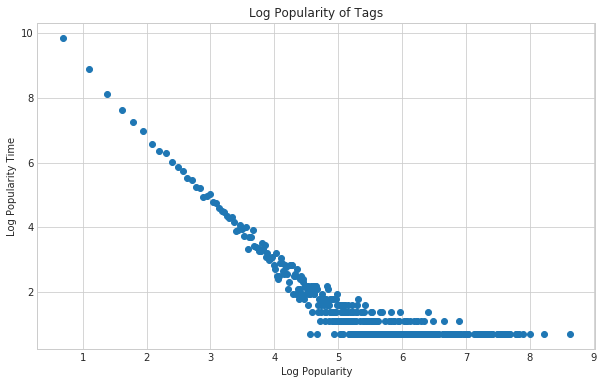

In [5]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

popularity = np.log1p(list(tag_counts.keys()))
popularity_time = np.log1p(list(tag_counts.values()))

plt.scatter(popularity, popularity_time)
plt.title("Log Popularity of Tags")
plt.xlabel("Log Popularity")
plt.ylabel("Log Popularity Time")

## 基于标签的基本推荐

### Load Data

In [2]:
from main.util.delicious_reader import split_data

origin_train, origin_test = split_data(
                filename="data/delicious-2k/user_taggedbookmarks-timestamps.dat",
                k=1,
                cv_folder=10
)

In [3]:
print("Len Train : {train_count},Len Test : {test_count}".
      format(train_count = len(origin_train), test_count=len(origin_test)))

Len Train : 397695,Len Test : 39898


### Training

In [4]:
from main.chapter4.base_rec import BaseRec
from main.chapter4 import base_rec
from imp import reload
reload(base_rec)

base_model = BaseRec()
base_model.train(origin_data=origin_train)

### Evaluation

#### 整理测试集

In [5]:
test = dict()
for user_id, item_id, tag_id in origin_test:
    test.setdefault(user_id,[])
    test[user_id].append(item_id)

#### 计算训练集的流行度

In [15]:
def popularity(data):
    """计算数据的流行度
    
    :param data: tuple(int,int,int)
        数据集（user_id, item_id, tag_id）
    :return: dict{int, int}
        流行度字典{item_id:流行度}
    """
    item_popularity = dict()
    for user_id, item_id, tag_id in data:
        item_popularity.setdefault(item_id, 0)
        item_popularity[item_id] += 1
    return item_popularity

In [ ]:
# 计算训练集的流行度
train_item_popularity = popularity(origin_train)

#### 找出所有商品ID（用于计算覆盖率）

In [7]:
all_items = set()

for user_id, item_id, tag_id in origin_train:
    all_items.add(item_id)
for user_id, item_id, tag_id in origin_test:
    all_items.add(item_id)

In [16]:
from main.util import metric

def evaluation(test,recommend):
    """评价
    Args:
        test: dict {user_id : [买过的商品1，买过的商品2,...]}
            测试集
        recommend:dict {user_id : [推荐的商品1，推荐的商品2,...]}
            测试集推荐结果
    Return: tuple
        (precision,recall,coverage,popularity)
    """
    precision = metric.precision(recommends=recommend, tests=test)
    recall = metric.recall(recommends=recommend, tests=test)
    coverage = metric.coverage(all_items=all_items, recommends=recommend)
    popularity = metric.popularity(item_popular=train_item_popularity, recommends=recommend)
    
    return precision,recall,coverage,popularity


In [9]:
recommend_count = 20

recommend_users = list(test.keys())
recommends = base_model.recommend_users(
                users=recommend_users,
                recommend_count= recommend_count
)
precision, recall, coverage, popularity = evaluation(test, recommends)

print("Precision : {}".format(precision))
print("Recall : {}".format(recall))
print("Coverage : {}".format(coverage))
print("Popularity : {}".format(popularity))

Precision : 0.0004402100430776971
Recall : 0.0003961965134706815
Coverage : 0.06194472935296072
Popularity : 3.7644381689807713


## 基于TFIDF的改进

### Load Data

In [26]:
from main.util.delicious_reader import split_data

origin_train, origin_test = split_data(
                filename="data/delicious-2k/user_taggedbookmarks-timestamps.dat",
                k=1,
                cv_folder=10
)

In [9]:
print("Len Train : {train_count},Len Test : {test_count}".
      format(train_count = len(origin_train), test_count=len(origin_test)))

Len Train : 397695,Len Test : 39898


### Training

In [27]:
from main.chapter4.TFIDF_rec import TagBasedTFIDF
from main.chapter4 import TFIDF_rec
from imp import reload
reload(TFIDF_rec)

tfidf_model = TagBasedTFIDF()
tfidf_model.train(origin_data=origin_train)

### Evaluation

#### 整理测试集

In [28]:
test = dict()
for user_id, item_id, tag_id in origin_test:
    test.setdefault(user_id,[])
    test[user_id].append(item_id)
    
test = {user_id : set(items) for user_id, items in test.items()}
    

#### 计算训练集的流行度

In [29]:
def popularity(data):
    """计算数据的流行度
    
    :param data: tuple(int,int,int)
        数据集（user_id, item_id, tag_id）
    :return: dict{int, int}
        流行度字典{item_id:流行度}
    """
    item_popularity = dict()
    for user_id, item_id, tag_id in data:
        item_popularity.setdefault(item_id, 0)
        item_popularity[item_id] += 1
    return item_popularity

In [30]:
# 计算训练集的流行度
train_item_popularity = popularity(origin_train)

####  找出所有商品（用于计算覆盖率）

In [31]:
all_items = set()

for user_id, item_id, tag_id in origin_train:
    all_items.add(item_id)
for user_id, item_id, tag_id in origin_test:
    all_items.add(item_id)

In [32]:
from main.util import metric

def evaluation(test,recommend):
    """评价
    Args:
        test: dict {user_id : [买过的商品1，买过的商品2,...]}
            测试集
        recommend:dict {user_id : [推荐的商品1，推荐的商品2,...]}
            测试集推荐结果
    Return: tuple
        (precision,recall,coverage,popularity)
    """
    precision = metric.precision(recommends=recommend, tests=test)
    recall = metric.recall(recommends=recommend, tests=test)
    coverage = metric.coverage(all_items=all_items, recommends=recommend)
    popularity =   metric.popularity(
        item_popular=train_item_popularity,recommends=recommend)
    
    return precision,recall,coverage,popularity

In [34]:
recommend_count = 20

recommend_users = list(test.keys())
recommends = tfidf_model.recommend_users(
                users=recommend_users,
                recommend_count= recommend_count
)
precision, recall, coverage, popularity = evaluation(test, recommends)

print("Precision : {}".format(precision))
print("Recall : {}".format(recall))
print("Coverage : {}".format(coverage))
print("Popularity : {}".format(popularity))

Precision : 0.0004402100430776971
Recall : 0.0003961965134706815
Coverage : 0.08370050416768993
Popularity : 3.671448547935441


## TFIDF++

### Load Data

In [35]:
from main.util.delicious_reader import split_data

origin_train, origin_test = split_data(
                filename="data/delicious-2k/user_taggedbookmarks-timestamps.dat",
                k=1,
                cv_folder=10
)

In [36]:
print("Len Train : {train_count},Len Test : {test_count}".
      format(train_count = len(origin_train), test_count=len(origin_test)))

Len Train : 397695,Len Test : 39898


### Training

In [38]:
from main.chapter4.TFIDF_plus_rec import TagBasedTFIDFPlus
from main.chapter4 import TFIDF_plus_rec
from imp import reload
reload(TFIDF_plus_rec)

tfidf_plus_model = TagBasedTFIDFPlus()
tfidf_plus_model.train(origin_data=origin_train)

### Evaluation

#### 整理测试集

In [39]:
test = dict()
for user_id, item_id, tag_id in origin_test:
    test.setdefault(user_id,[])
    test[user_id].append(item_id)
    
test = {user_id : set(items) for user_id, items in test.items()}

#### 计算训练集的流行度

In [40]:
def popularity(data):
    """计算数据的流行度
    
    :param data: tuple(int,int,int)
        数据集（user_id, item_id, tag_id）
    :return: dict{int, int}
        流行度字典{item_id:流行度}
    """
    item_popularity = dict()
    for user_id, item_id, tag_id in data:
        item_popularity.setdefault(item_id, 0)
        item_popularity[item_id] += 1
    return item_popularity

In [41]:
# 计算训练集的流行度
train_item_popularity = popularity(origin_train)

#### 找出所有商品（用于计算覆盖率）

In [42]:
all_items = set()

for user_id, item_id, tag_id in origin_train:
    all_items.add(item_id)
for user_id, item_id, tag_id in origin_test:
    all_items.add(item_id)

In [43]:
from main.util import metric

def evaluation(test,recommend):
    """评价
    Args:
        test: dict {user_id : [买过的商品1，买过的商品2,...]}
            测试集
        recommend:dict {user_id : [推荐的商品1，推荐的商品2,...]}
            测试集推荐结果
    Return: tuple
        (precision,recall,coverage,popularity)
    """
    precision = metric.precision(recommends=recommend, tests=test)
    recall = metric.recall(recommends=recommend, tests=test)
    coverage = metric.coverage(all_items=all_items, recommends=recommend)
    popularity =   metric.popularity(
        item_popular=train_item_popularity,recommends=recommend)
    
    return precision,recall,coverage,popularity

In [44]:
recommend_count = 20

recommend_users = list(test.keys())
recommends = tfidf_plus_model.recommend_users(
                users=recommend_users,
                recommend_count= recommend_count
)
precision, recall, coverage, popularity = evaluation(test, recommends)

print("Precision : {}".format(precision))
print("Recall : {}".format(recall))
print("Coverage : {}".format(coverage))
print("Popularity : {}".format(popularity))

Precision : 0.0004087664685721473
Recall : 0.00036789676250848993
Coverage : 0.1766609363939731
Popularity : 2.766799687261488


## 标签的相关性报告

In [8]:
from main.util.delicious_reader import split_data

origin_train, origin_test = split_data(
                filename="data/delicious-2k/user_taggedbookmarks-timestamps.dat",
                k=1,
                cv_folder=10
)

In [5]:
from main.chapter4 import sim_tag_rec
from imp import reload
reload(sim_tag_rec)

model = sim_tag_rec.SimTagTFIDF()
model.train(origin_data=origin_train)

In [6]:
similarity_matrix = model.tag_vec_report(tops=30)

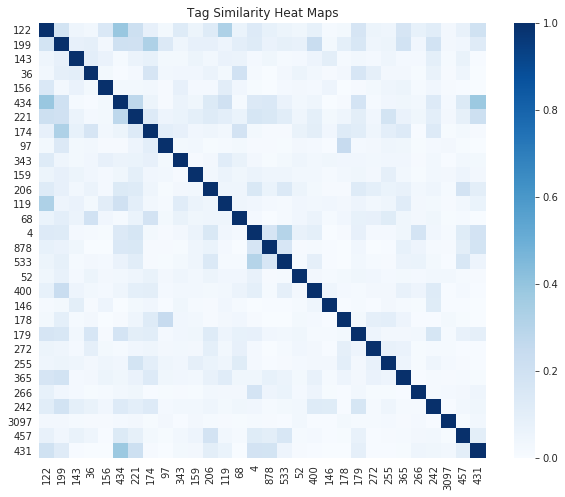

In [7]:
import seaborn as sns
sns.set_style("whitegrid")
plt.figure(figsize=(10,8))

plt.title("Tag Similarity Heat Maps")
plt.xlabel("Tags")
plt.ylabel("Tags")
sns.heatmap(similarity_matrix,cmap=plt.cm.Blues,)


## 考虑加入标签协同过滤方式

### Training

In [11]:
from main.chapter4 import sim_tag_rec
from imp import reload
reload(sim_tag_rec)

model = sim_tag_rec.SimTagTFIDF()
model.train(origin_train)

### Evaluation

#### 整理测试集

In [12]:
test = dict()
for user_id, item_id, tag_id in origin_test:
    test.setdefault(user_id,[])
    test[user_id].append(item_id)
    
test = {user_id : set(items) for user_id, items in test.items()}

#### 计算测试集流行度

In [13]:
def popularity(data):
    """计算数据的流行度
    
    :param data: tuple(int,int,int)
        数据集（user_id, item_id, tag_id）
    :return: dict{int, int}
        流行度字典{item_id:流行度}
    """
    item_popularity = dict()
    for user_id, item_id, tag_id in data:
        item_popularity.setdefault(item_id, 0)
        item_popularity[item_id] += 1
    return item_popularity

In [14]:
# 计算训练集的流行度
train_item_popularity = popularity(origin_train)

#### 找出所有商品（用于计算覆盖率）

In [15]:
all_items = set()

for user_id, item_id, tag_id in origin_train:
    all_items.add(item_id)
for user_id, item_id, tag_id in origin_test:
    all_items.add(item_id)

In [16]:
from main.util import metric

def evaluation(test,recommend):
    """评价
    Args:
        test: dict {user_id : [买过的商品1，买过的商品2,...]}
            测试集
        recommend:dict {user_id : [推荐的商品1，推荐的商品2,...]}
            测试集推荐结果
    Return: tuple
        (precision,recall,coverage,popularity)
    """
    precision = metric.precision(recommends=recommend, tests=test)
    recall = metric.recall(recommends=recommend, tests=test)
    coverage = metric.coverage(all_items=all_items, recommends=recommend)
    popularity =   metric.popularity(
        item_popular=train_item_popularity,recommends=recommend)
    
    return precision,recall,coverage,popularity

In [17]:
recommend_count = 20

recommend_users = list(test.keys())
recommends = model.recommend_users(
                users=recommend_users,
                recommend_count= recommend_count
)
precision, recall, coverage, popularity = evaluation(test, recommends)

print("Precision : {}".format(precision))
print("Recall : {}".format(recall))
print("Coverage : {}".format(coverage))
print("Popularity : {}".format(popularity))

Precision : 0.0004087664685721473
Recall : 0.0003665999266800147
Coverage : 0.17732545541221847
Popularity : 2.7667086359589597


# Chapter5

## 时间特性

In [16]:
from main.util import delicious_reader
from imp import reload
reload(delicious_reader)

path = "data/delicious-2k/user_taggedbookmarks-timestamps.dat"

tag_time = delicious_reader.read_tag_time(path)
tag_time_df = pd.DataFrame(tag_time,columns=["UserID","ItemID","TagID","Time"])
tag_time_df.head()

,UserID,ItemID,TagID,Time
0,8,1,1,2010-11-09 06:29:22
1,8,2,1,2010-11-09 06:25:59
2,8,7,1,2010-11-09 01:55:01
3,8,7,6,2010-11-09 01:55:01
4,8,7,7,2010-11-09 01:55:01


### 找到打标签最多的商品

In [24]:
tag_time_df.ItemID.value_counts().head()

5448     158
8981     154
11115    147
2720     142
1752     142
Name: ItemID, dtype: int64

### 热度统计

In [66]:
Item_5448 = tag_time_df.loc[tag_time_df.ItemID == 5448]
Item_5448["Date"] = Item_5448.Time.apply(lambda x: x.date())
Item_5448 = Item_5448.groupby("Date",sort=True).count()
Item_5448.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,UserID,ItemID,TagID,Time
Date,,,,
2010-06-25,4,4,4,4
2010-08-11,40,40,40,40
2010-08-12,15,15,15,15
2010-08-13,9,9,9,9
2010-08-16,6,6,6,6


### 画图

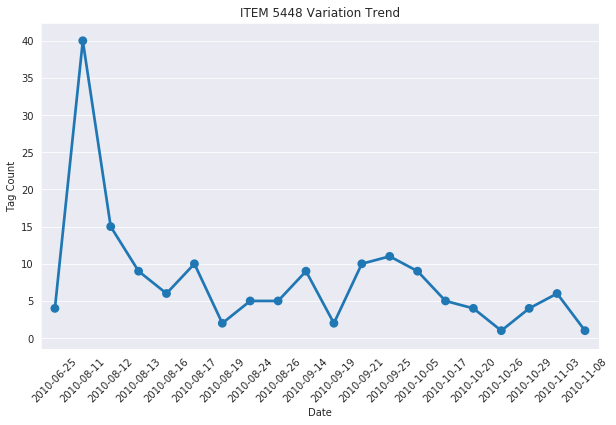

In [80]:
plt.figure(figsize=(10,6))
sns.set_style("darkgrid")

plt.xticks(rotation=45)
plt.title("ITEM 5448 Variation Trend")

Item_5448["Tag Count"] = Item_5448["ItemID"]
sns.pointplot(x=Item_5448.index,y="Tag Count",data=Item_5448)

## 最近最热门

### 数据集

In [17]:
from main.util import delicious_reader

data = delicious_reader.read_tag_time("data/delicious-2k/user_taggedbookmarks-timestamps.dat")
data = [[user_id,item_id,ui_time] for user_id, item_id, tag_id, ui_time in data]

### 模型

In [26]:
from imp import reload
from main.chapter5 import most_popularity
reload(most_popularity)

model = most_popularity.RecentPopular()
model.train(data)

### 推荐

In [32]:
print("推荐的最近热门商品ID:{0}".format(model.recommend(alpha=0.1)))

推荐的最近热门商品ID:[5448, 8981, 11115, 1752, 2720, 1087, 7535, 1303, 4114, 4041]
